```
    __
   (__      /_      _        /
  (__  (_/ (   (-  (  /) (- . 
                     /
```

## Segmentation Experiments

Segmentation Tests  
Author: `@hughshuwang` 

In [1]:
%matplotlib inline

from __future__ import print_function

import IPython.display as ipd

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from presets import Preset

import librosa as rs
import librosa.feature as ft
import librosa.display as dp
import librosa.segment as sg

import sklearn.cluster

import torch
import torch.nn as nn
import torch.functional as F

SAMPLE_RATE = 22050

file = '../data-raw/sample2.mp3'
y, sr = rs.load(file, sr = SAMPLE_RATE, duration=None, offset=0.0)

# mel_highres = feature.melspectrogram(y, n_fft=2**11, hop_length=512)
# mel_db = rs.power_to_db(mel_highres, ref=np.max)

# plt.figure(figsize=(12, 3)) # ax = plt.subplot(3, 1, 1)
# plt.subplot(3, 1, 2, sharex=ax, sharey=ax)
# display.specshow(mel_db, y_axis='mel', x_axis='time', hop_length = 512)
# plt.title('44100/1024/4096')

In [2]:
cqt = rs.amplitude_to_db(np.abs(rs.cqt(y, sr=sr)), ref=np.max)
# stft = rs.amplitude_to_db(np.abs(rs.stft(y)), ref=np.max) # not as good as cqt

tempo, beats = rs.beat.beat_track(y=y, sr=sr, trim=False)
mfcc = ft.mfcc(y=y, sr=sr)

cqt_sync = rs.util.sync(cqt, beats, aggregate=np.median)
mfcc_sync = rs.util.sync(mfcc, beats)
beat_times = rs.frames_to_time(rs.util.fix_frames(beats, x_min=0, x_max=cqt.shape[1]), sr=sr)

/usr/local/lib/python2.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


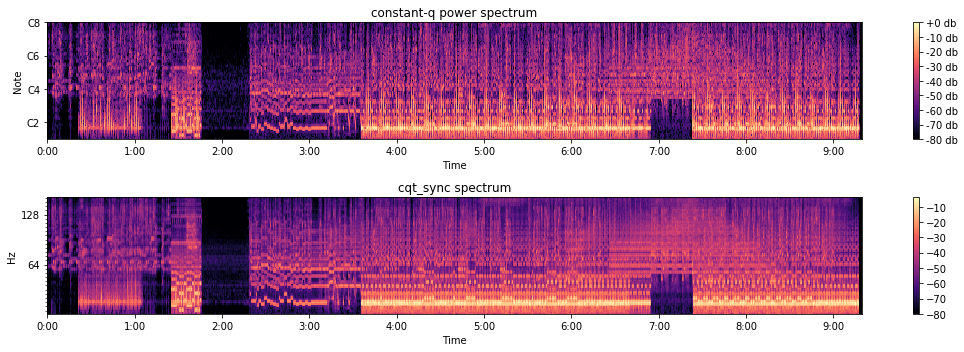

In [3]:
plt.figure(figsize=(15, 5))

plt.subplot(2, 1, 1)
dp.specshow(cqt, sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f db')
plt.title('constant-q power spectrum')
plt.tight_layout()

plt.subplot(2, 1, 2)
dp.specshow(cqt_sync, bins_per_octave=12*3, y_axis='cqt_hz', x_axis='time', x_coords=beat_times)
plt.colorbar()
plt.title('cqt_sync spectrum')

plt.tight_layout()

In [4]:
R = sg.recurrence_matrix(cqt_sync, width=3, mode='affinity', sym=True)
df = sg.timelag_filter(scipy.ndimage.median_filter)
Rf = df(R, size=(1, 7))

path_distance = np.sum(np.diff(mfcc_sync, axis=1)**2, axis=0)
path_sim = (lambda x: np.exp(-x / np.median(x)))(path_distance)
R_path = (lambda x: np.diag(x, k=1) + np.diag(x, k=-1))(path_sim)

deg_path = np.sum(R_path, axis=1)
deg_rec = np.sum(Rf, axis=1)

mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)
A = mu * Rf + (1 - mu) * R_path

L = scipy.sparse.csgraph.laplacian(A, normed=True) # and its spectral decomposition
evals, evecs = scipy.linalg.eigh(L)

# We can clean this up further with a median filter. # This can help smooth over small discontinuities
evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))

# cumulative normalization is needed for symmetric normalize laplacian eigenvectors
Cnorm = np.cumsum(evecs**2, axis=1)**0.5

# If we want k clusters, use the first k normalized eigenvectors.
# Fun exercise: see how the segmentation changes as you vary k
k = 4
X = evecs[:, :k] / Cnorm[:, k-1:k]
KM = sklearn.cluster.KMeans(n_clusters=k)
seg_ids = KM.fit_predict(X)

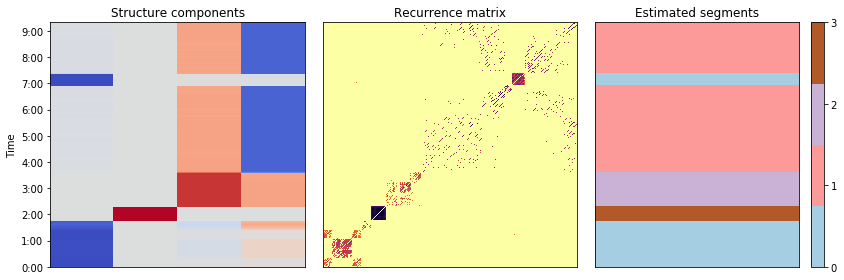

In [5]:
plt.figure(figsize=(12, 4))
colors = plt.get_cmap('Paired', k)

plt.subplot(1, 3, 2)
dp.specshow(Rf, cmap='inferno_r')
plt.title('Recurrence matrix')

plt.subplot(1, 3, 1)
dp.specshow(X, y_axis='time', y_coords=beat_times)
plt.title('Structure components')

plt.subplot(1, 3, 3)
dp.specshow(np.atleast_2d(seg_ids).T, cmap=colors)
plt.title('Estimated segments')
plt.colorbar(ticks=range(k))

plt.tight_layout()

In [6]:
bound_beats = 1 + np.flatnonzero(seg_ids[:-1] != seg_ids[1:])
# Count beat 0 as a boundary
bound_beats = rs.util.fix_frames(bound_beats, x_min=0)
# Compute the segment label for each boundary
bound_segs = list(seg_ids[bound_beats])
# Convert beat indices to frames
bound_frames = beats[bound_beats]

# Make sure we cover to the end of the track
bound_frames = rs.util.fix_frames(bound_frames, x_min=None, x_max=cqt.shape[1]-1)

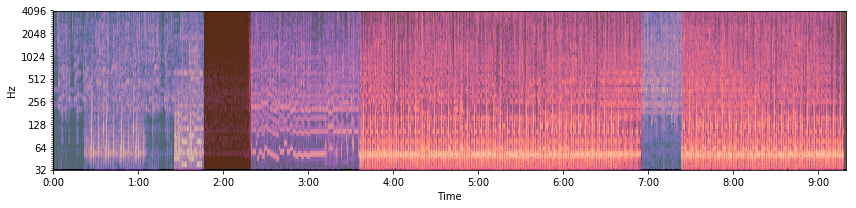

In [8]:
plt.figure(figsize=(12, 3))

bound_times = rs.frames_to_time(bound_frames)
freqs = rs.cqt_frequencies(n_bins=cqt.shape[0], fmin=rs.note_to_hz('C1'))

rs.display.specshow(cqt, y_axis='cqt_hz', sr=sr, x_axis='time')
ax = plt.gca()

for interval, label in zip(zip(bound_times, bound_times[1:]), bound_segs):
    ax.add_patch(patches.Rectangle((interval[0], freqs[0]), interval[1] - interval[0],
                                   freqs[-1], facecolor=colors(label), alpha=0.50))

plt.tight_layout()